In [1]:
!pip install loguru cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 30.5 MB/s eta 0:00:00


In [14]:
import numpy as np
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from loguru import logger


class SLADataset(Dataset):
  def __init__(self, file):
      self.data = xr.open_dataset(file)

  def __len__(self):
    return len(self.data.time)

  def __getitem__(self, idx):
    sla = self.data.isel(time=idx).sla.values
    dx_sla = np.gradient(sla, axis=-1)
    dy_sla = np.gradient(sla, axis=-2)
    sla = np.stack([sla])
    d_sla = np.stack([dx_sla, dy_sla])
    sla = np.nan_to_num(sla)
    d_sla = np.nan_to_num(d_sla)
    return torch.from_numpy(sla), torch.from_numpy(d_sla)


class Conv(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(1, 2, kernel_size=3, padding=1, bias=False)

  def forward(self, x):
    x = self.conv(x)
    return x


lr = 1e-2
epochs = 200
batch_size = 1

dataset = SLADataset("dt_global_allsat_phy_l4_20211209_20220422.nc")
data = DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = Conv()
loss_fn = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

globe_step = 0
for epoch in range(epochs):
  # train
  model.train()
  for step, batch in enumerate(data):
      inputs, targets = batch

      optimizer.zero_grad()
      outputs = model(inputs.float())
      loss = loss_fn(outputs, targets.float())
      loss.backward()
      optimizer.step()

      loss, current = loss.mean(), step * batch_size
      if globe_step%25 == 0:
        logger.info(f"Loss: {loss:>6f}, step={epoch}")
      globe_step += 1

torch.save(model.state_dict(),f'conv.pth')

2023-11-13 08:21:38.565 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.031657, step=0
2023-11-13 08:21:40.964 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.010740, step=25
2023-11-13 08:21:43.376 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.006683, step=50
2023-11-13 08:21:45.734 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.004006, step=75
2023-11-13 08:21:48.670 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.002541, step=100
2023-11-13 08:21:51.113 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.002283, step=125
2023-11-13 08:21:53.506 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.002111, step=150
2023-11-13 08:21:55.889 | INFO     | __main__:<cell line: 50>:64 - Loss: 0.002003, step=175


<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, uv: 2)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Dimensions without coordinates: uv
Data variables:
    d_sla      (uv, latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    d_sla_p    (uv, latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    delta      (uv, latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2021-12-09T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2021-12-08T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

<xarray.Dataset>
Dimensions:    (uv: 2, latitude: 120, longitude: 100)
Coordinates:
  * latitude   (latitude) float32 0.125 0.375 0.625 0.875 ... 29.38 29.62 29.88
  * longitude  (longitude) float32 100.1 100.4 100.6 100.9 ... 124.4 124.6 124.9
Dimensions without coordinates: uv
Data variables:
    d_sla      (uv, latitude, longitude) float64 0.0 0.0 0.0 ... -0.0032 -0.0052
    d_sla_p    (uv, latitude, longitude) float32 0.0 0.0 ... -0.002173 -0.005258
    delta      (uv, latitude, longitude) float64 0.0 0.0 ... 0.001027 -5.817e-05
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2021-12-09T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2021-12-08T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

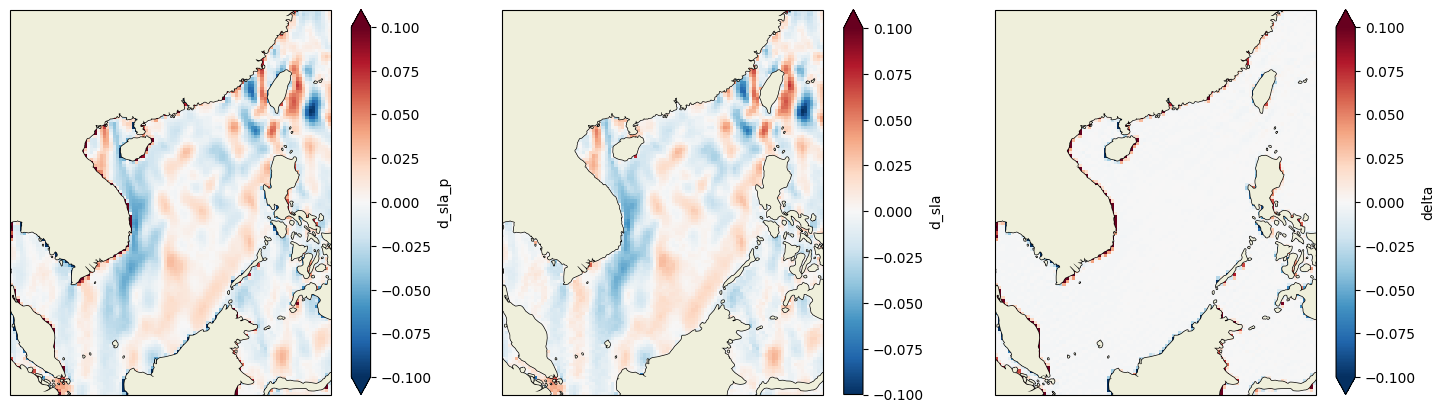

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

sla, d_sla = dataset[0]
with torch.no_grad():
  dp = model(sla.float()).numpy()

ds = xr.open_dataset("dt_global_allsat_phy_l4_20211209_20220422.nc")
ds = ds[["latitude", "longitude"]]

ds["d_sla"] = (("uv","latitude","longitude"), d_sla.numpy())
ds["d_sla_p"] = (("uv","latitude","longitude"), dp)
ds["delta"] = ds["d_sla_p"] - ds["d_sla"]
display(ds)
ds = ds.where((ds.longitude>100)&(ds.longitude<125)&(ds.latitude>0)&(ds.latitude<30),drop=True)
display(ds)

fig = plt.figure(figsize=[18,5])
ax = fig.add_subplot(131, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=2)
ds.d_sla_p[0].plot.imshow(ax=ax, vmin=-0.1,vmax=0.1, cmap="RdBu_r")

ax = fig.add_subplot(132, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=2)
ds.d_sla[0].plot.imshow(ax=ax, vmin=-0.1,vmax=0.1, cmap="RdBu_r")

ax = fig.add_subplot(133, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=2)
ds.delta[0].plot.imshow(ax=ax, vmin=-0.1,vmax=0.1, cmap="RdBu_r")

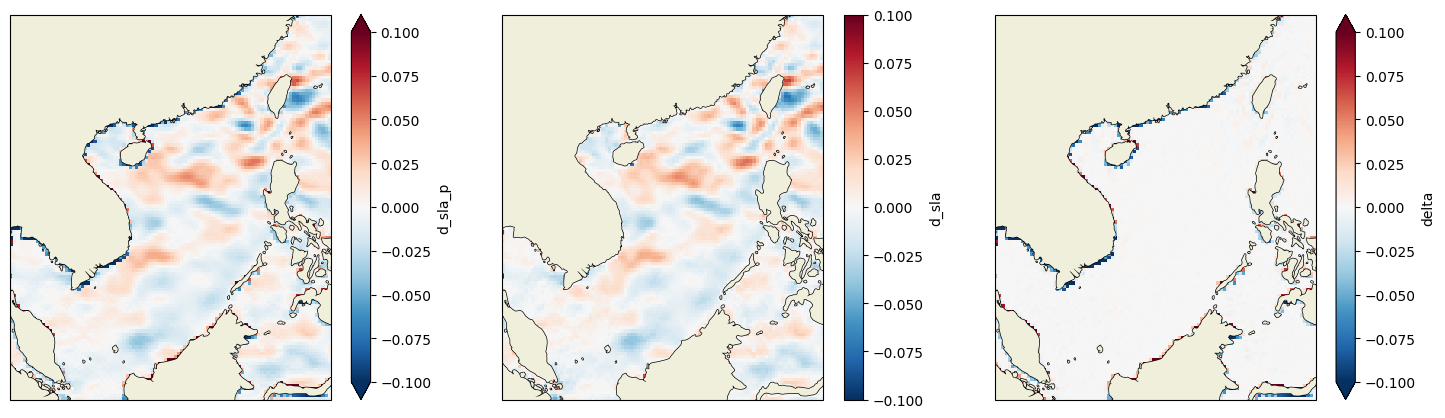

In [11]:
fig = plt.figure(figsize=[18,5])
ax = fig.add_subplot(131, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=2)
ds.d_sla_p[1].plot.imshow(ax=ax, vmin=-0.1,vmax=0.1, cmap="RdBu_r")

ax = fig.add_subplot(132, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=2)
ds.d_sla[1].plot.imshow(ax=ax, vmin=-0.1,vmax=0.1, cmap="RdBu_r")

ax = fig.add_subplot(133, projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=2)
ds.delta[1].plot.imshow(ax=ax, vmin=-0.1,vmax=0.1, cmap="RdBu_r")

In [15]:
display(list(model.parameters()))

[Parameter containing:
 tensor([[[[-0.1085, -0.1291,  0.2378],
           [-0.2284,  0.1216,  0.1088],
           [-0.1796,  0.0122,  0.1623]]],
 
 
         [[[-0.1062, -0.2889, -0.1097],
           [-0.1211,  0.1899, -0.0766],
           [ 0.2239,  0.1073,  0.1784]]]], requires_grad=True)]